In [1]:
import os
import pickle
import timeit
from datetime import datetime
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nlct_dir_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/nlct_data/"

In [3]:
nlct_dates = sorted(os.listdir(nlct_dir_path))

#---Removing any non-date directory items
nlct_dates = [x for x in nlct_dates if len(x) == 8]

nlct_dates

['20220219',
 '20220914',
 '20230417',
 '20230427',
 '20230901',
 '20230907',
 '20230908',
 '20230909']

Creating the static value function: 

In [4]:
def find_static_features(BTD_c, nlct_dir_path, nlct_date):

    #--- Initialize an array of 1's in the shape of the final image
    BTD_prod = [ [1]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]

    for filename in sorted(os.listdir(nlct_dir_path+nlct_date+'/')):
            #print(filename)

            #--- Open the NLCT file
            file = open(nlct_dir_path+nlct_date+'/'+filename, 'rb')
            BTD = pickle.load(file)
            file.close()

            #--- Crop to the specified region
            BTD = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
            BTD = BTD.dropna(dim="y", how="all")
            BTD = BTD.dropna(dim="x", how="all")

            #--- Set negative values to zero
            BTD = np.where(BTD < 0, 0, BTD)

            #--- Multiply to only enhance static clouds
            BTD_prod = BTD_prod*BTD

            #--- Limit runaway large values to 3
            BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)
            
            #--- Convert BTD prod (2d array) to value
            static_value = np.nansum(BTD_prod)
            
            #--- Create date variable
            date = datetime.strptime(nlct_date, "%Y%m%d")
    
    return date, static_value
    

Create sample to use as framework for loop:

In [5]:
sample_date = '20220914'
sample_nlct_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/nlct_data/"+sample_date+"/"
sample_filename = 'goes_e_ntlc_'+sample_date[0:4]+'_'+sample_date[4:6]+'_'+sample_date[6:8]+'_00H_00M'

file = open(sample_nlct_path+sample_filename, 'rb')
BTD = pickle.load(file)
file.close()

#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

BTD_c = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
BTD_c = BTD_c.dropna(dim="y", how="all")
BTD_c = BTD_c.dropna(dim="x", how="all")

Running the static value function for each date in NLCT directory: 

In [6]:
data = {'Date': [], 'StaticValue': []}
df = pd.DataFrame(data)

In [7]:
for nlct_date in tqdm(nlct_dates, desc="Processing", ncols=100):
    date, static_value = find_static_features(BTD_c, nlct_dir_path, nlct_date)
    #print(date, static_value)
    
    data_to_add = {
        'Date': date,
        'StaticValue': static_value
    }
    df = df.append(data_to_add, ignore_index=True)

Processing: 100%|█████████████████████████████████████████████████████| 8/8 [03:46<00:00, 28.25s/it]


In [8]:
df

,Date,StaticValue
0,2022-02-19,3177.301217
1,2022-09-14,4133.602799
2,2023-04-17,64937.395281
3,2023-04-27,75001.877019
4,2023-09-01,3632.184383
5,2023-09-07,7849.115963
6,2023-09-08,57991.848358
7,2023-09-09,992.218276


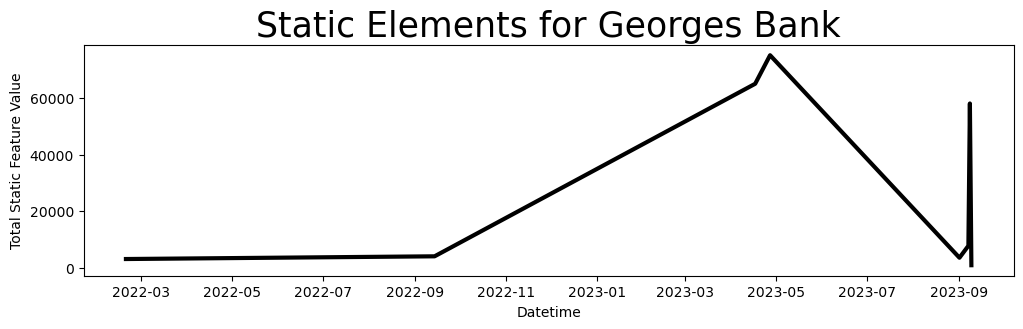

In [9]:
fig,ax=plt.subplots(1, figsize=(12,3))
ax.set_ylabel("Total Static Feature Value", fontsize=10)
ax.set_xlabel("Datetime", fontsize=10)
ax.set_title("Static Elements for Georges Bank", fontsize=25)

ax.plot(df.Date, df.StaticValue, c='black', linewidth=3)